# Reading vector data

The `VectorSource` is Raster Vision's abstraction for reading from a source of vector data. Besides reading the data, `VectorSource`s also convert geometries from map to pixel coordinates and perform some data cleaning such as removing empty geometries and splitting apart multi-part geometries (e.g. MultiPolygon etc.).

---

One concrete implementation of it is the `GeoJSONVectorSource` which can read vector data from a GeoJSON file.

In [1]:
from rastervision.core.data import GeoJSONVectorSource, RasterioCRSTransformer

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
label_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson'

crs_transformer = RasterioCRSTransformer.from_uri(img_uri)
vector_source = GeoJSONVectorSource(
    label_uri, crs_transformer, ignore_crs_field=True)

We can read data from a VectorSource in three different formats:

1. as GeoJSON dict (`vector_source.get_geojson()`)
2. as Shapely geoms (`vector_source.get_geoms()`)
3. as a GeoPandas `GeoDataFrame` (`vector_source.get_dataframe()`)

Each of these is shown in the following cells.

---

### `.get_geojson()`

In [2]:
geojson = vector_source.get_geojson()
geojson['features'][:3]

2022-09-13 12:06:41:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson.


[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((552.0, 587.0),
     (485.0, 587.0),
     (485.0, 604.0),
     (482.0, 604.0),
     (482.0, 621.0),
     (503.0, 621.0),
     (503.0, 624.0),
     (515.0, 624.0),
     (515.0, 633.0),
     (552.0, 633.0),
     (552.0, 587.0)),)},
  'properties': {'OBJECTID': 0,
   'FID_VEGAS_': 0,
   'Id': 0,
   'FID_Vegas': 0,
   'Name': 'None',
   'AREA': 0.0,
   'Shape_Leng': 0.0,
   'Shape_Le_1': 0.0,
   'SISL': 0.0,
   'OBJECTID_1': 0,
   'Shape_Le_2': 0.0,
   'Shape_Le_3': 0.000625,
   'Shape_Area': 0.0,
   'partialBuilding': 0.0,
   'partialDec': 1.0}},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((561.0, 533.0),
     (562.0, 487.0),
     (486.0, 486.0),
     (485.0, 527.0),
     (541.0, 528.0),
     (541.0, 532.0),
     (561.0, 533.0)),)},
  'properties': {'OBJECTID': 0,
   'FID_VEGAS_': 0,
   'Id': 0,
   'FID_Vegas': 0,
   'Name': 'None',
   'AREA': 0.0,
   'Shape_Leng': 0.0,
   'Shape_Le_1

---

### `.get_geoms()`

In [3]:
def plot_geoms(geoms: list, title=''):
    from matplotlib import pyplot as plt
    from matplotlib import patches as patches
    import numpy as np

    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == 'Polygon':
            xy = np.array(g.exterior)
            patch = patches.Polygon(xy, color='#55cc77', alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor='#005511', fill=None, alpha=1)
            ax.add_patch(patch)
        elif g.geom_type == 'LineString':
            xy = np.array(g.buffer(1).exterior)
            patch = patches.Polygon(xy, color='#005511', alpha=0.8)
            ax.add_patch(patch)
        else:
            raise NotImplementedError()
    ax.set_title(title, fontsize=14)
    ax.autoscale()
    plt.show()

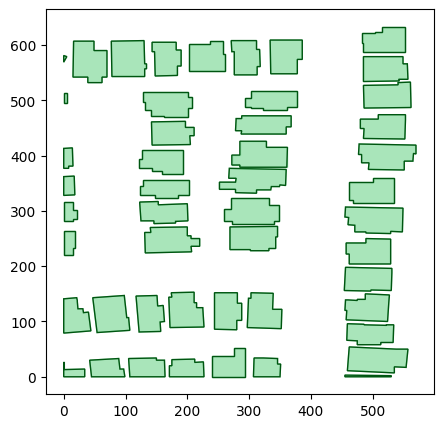

In [4]:
geoms = vector_source.get_geoms()
plot_geoms(geoms)

---

### `.get_dataframe()`

In [5]:
df = vector_source.get_dataframe()
df.head()

,geometry,OBJECTID,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec
0,"POLYGON ((552.000 587.000, 485.000 587.000, 48...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000625,0.0,0.0,1.0
1,"POLYGON ((561.000 533.000, 562.000 487.000, 48...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000658,0.0,0.0,1.0
2,"POLYGON ((553.000 465.000, 552.000 430.000, 48...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000627,0.0,0.0,1.0
3,"POLYGON ((551.000 374.000, 493.000 375.000, 49...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000744,0.0,0.0,1.0
4,"POLYGON ((535.000 315.000, 468.000 315.000, 46...",0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000634,0.0,0.0,1.0


<AxesSubplot:>

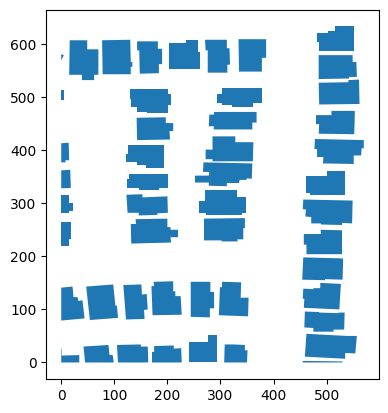

In [6]:
df.plot()

<hr style="border:2px solid gray">

## Transforming vector data using `VectorTransformer`s

Just like we can tansform rasters by specifying a series of `RasterTransformer`s, we can specify `VectorTransformer`s to transform vector data.

---

### Inferring class IDs for polygons

One very important `VectorTransformer` is the `ClassInferenceTransformer`.

When using vector data in machine learning, it is important that each polygon be labeled with an appropriate class ID. But often, your data will not have this property stored in the GeoJSON file.

The `ClassInferenceTransformer` can automatically infer and attach a `class_id` to each polygon read from the `VectorSource`. It can
1. Assign the same `class_id` to all the polygons (a very common use case).
2. Map class names to `class_id`s given a mapping.
3. Use a MapBox-style filter (see https://docs.mapbox.com/mapbox-gl-js/style-spec/other/#other-filter).

The example below shows how to use the first of the above methods.

In [7]:
from rastervision.core.data import (
    GeoJSONVectorSource, RasterioCRSTransformer, 
    RasterizedSource, ClassInferenceTransformer)

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
label_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson'

crs_transformer = RasterioCRSTransformer.from_uri(img_uri)
vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[ClassInferenceTransformer(default_class_id=1)])

In [8]:
df = vector_source.get_dataframe()
df[['geometry', 'class_id']].head()

2022-09-13 12:06:42:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson.


,geometry,class_id
0,"POLYGON ((552.000 587.000, 485.000 587.000, 48...",1
1,"POLYGON ((561.000 533.000, 562.000 487.000, 48...",1
2,"POLYGON ((553.000 465.000, 552.000 430.000, 48...",1
3,"POLYGON ((551.000 374.000, 493.000 375.000, 49...",1
4,"POLYGON ((535.000 315.000, 468.000 315.000, 46...",1


---

### Buffering Point and LineString geometries into polygons

`Point` and `LineString` geometries are not directly useable if doing, say, semantic segmentation. The cells below show an example of converting road geometries (given in the form of `LineString`s) into polygons.

Data source: https://spacenet.ai/spacenet-roads-dataset/

In [9]:
from rastervision.core.data import (
    GeoJSONVectorSource, RasterioCRSTransformer, 
    RasterizedSource, BufferTransformer)

img_uri = 's3://spacenet-dataset/spacenet/SN3_roads/train/AOI_4_Shanghai/PS-RGB/SN3_roads_train_AOI_4_Shanghai_PS-RGB_img999.tif'
label_uri = 's3://spacenet-dataset/spacenet/SN3_roads/train/AOI_4_Shanghai/geojson_roads/SN3_roads_train_AOI_4_Shanghai_geojson_roads_img999.geojson'

crs_transformer = RasterioCRSTransformer.from_uri(img_uri)

In [10]:
def plot_geoms(geoms: list, title=''):
    from matplotlib import pyplot as plt
    from matplotlib import patches as patches
    import numpy as np

    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == 'Polygon':
            xy = np.array(g.exterior)
            patch = patches.Polygon(xy, color='#55cc77', alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor='#005511', fill=None, alpha=1)
            ax.add_patch(patch)
        elif g.geom_type == 'LineString':
            xy = np.array(g.buffer(1).exterior)
            patch = patches.Polygon(xy, color='#005511', alpha=0.8)
            ax.add_patch(patch)
        else:
            raise NotImplementedError()
    ax.set_title(title, fontsize=14)
    ax.autoscale()
    plt.show()

2022-09-13 12:06:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN3_roads/train/AOI_4_Shanghai/geojson_roads/SN3_roads_train_AOI_4_Shanghai_geojson_roads_img999.geojson.


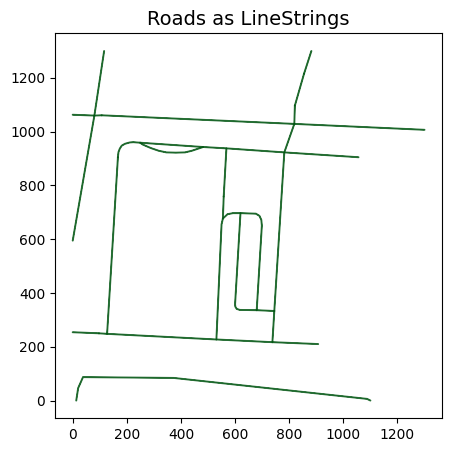

In [11]:
vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    ignore_crs_field=True)
plot_geoms(vector_source.get_geoms(), title='Roads as LineStrings')

2022-09-13 12:06:48:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN3_roads/train/AOI_4_Shanghai/geojson_roads/SN3_roads_train_AOI_4_Shanghai_geojson_roads_img999.geojson.


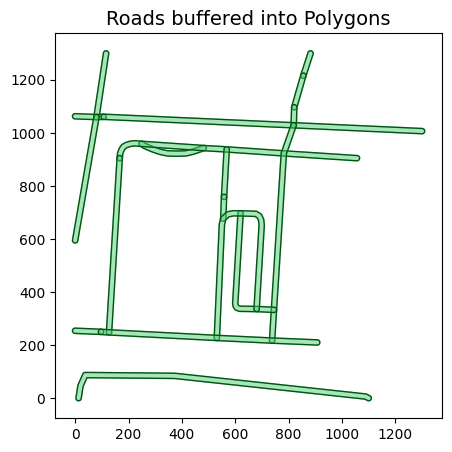

In [12]:
vector_source_buffered = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[BufferTransformer(geom_type='LineString', default_buf=10)])

plot_geoms(vector_source_buffered.get_geoms(), title='Roads buffered into Polygons')

<hr style="border:2px solid gray">

## Rasterizing vector data using `RasterizedSource`

Suppose we have semantic segmentation labels in the form of polygons. To use them for training, we will first need to convert them into rasters. Raster Vision allows accomplishing this using the `RasterizedSource` class.

The `RasterizedSource` is a `RasterSource` that reads data from a `VectorSource` (rather than an image file) and then converts it into rasters. It can be indexed like any other `RasterSource`.

In [13]:
from rastervision.core.data import (
    GeoJSONVectorSource, RasterioCRSTransformer, 
    RasterizedSource, ClassInferenceTransformer)

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
label_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson'

crs_transformer = RasterioCRSTransformer.from_uri(img_uri)
vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[ClassInferenceTransformer(default_class_id=1)])

rasterized_source = RasterizedSource(
    vector_source,
    background_class_id=0,
    # Normally we'd pass in the RasterSource's extent, but we don't have that here.
    extent=vector_source.extent)

2022-09-13 12:06:49:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson.


In [14]:
chip = rasterized_source[:400, :400]
chip.shape

(400, 400, 1)

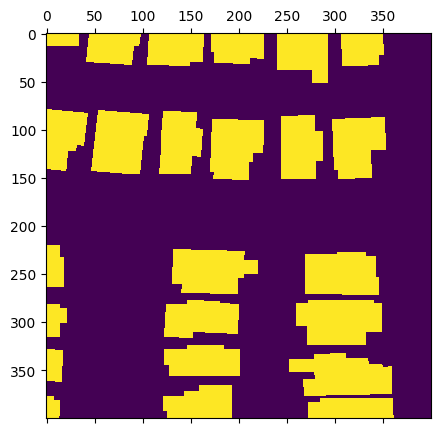

In [15]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip)
plt.show()